## Concept Extraction on Restricted ImageNet (20 classes)

#### Step 0 - Objective definition

To demonstrate the effectiveness of Concept Extraction, we train the model to learn the concept of `fins` in order to retrive images of `greate white shark` and `tiger shark`.

#### Step 1 - Load necessary modules and set a seed to reproduce same results.

In [1]:
from untangle import UntangleAI
untangle_ai = UntangleAI()
import os
import torch
import pandas as pd
import shutil
import random
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from models.custom_vgg import CustomVgg16 # we have modified VGG16 to output 20 class probabilities

def seed_torch(seed=35):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed) # if you are using multi-GPU.
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True
seed_torch(19)

#### Step 3 - Provide necessary args to perform concept extraction. Please take note of the following characteristics of some arguments

* `mname` [`<class str>`] - base name / prefix to generate visualization files
* `batch_size` [`<class int>`, `default:16`] - batch size to scan the training data and learn internal statistics. We observed that a Tesla K80, 12Gb GPU can accommodate a batch size of `16` for a standard (224,224) RGB image
* `num_classes` [`<class int>`] - number of classes in the dataset

In [2]:
class Args:
    mname = 'vgg16_imgnet20'
    train_data_path = './data/concept_data/fin/' # provide path containing concept images
    test_data_path = './data/imagenet20_data/test/' # provide path containing test images
    save_path = './results/fin_concept_results/' # provide path to save ranked concepts list
    batch_size = 4
    img_size = (3,224,224)
    num_classes = 20

#### Step 4 - Define data / model paths and build model

In [3]:
args = Args()
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
module_path = os.path.abspath('')
base_model_path = os.path.join(module_path, 'models')
model_ckpt_path = os.path.join(base_model_path, 'vgg16_imgnet20_pretrained.pth')
if(not os.path.exists(args.save_path)):
    os.makedirs(args.save_path)
if(not os.path.isfile(model_ckpt_path)):
    raise FileNotFoundError(model_ckpt_path)

print("Loading model checkpoint...", end="", flush=True)
model = CustomVgg16(num_classes=args.num_classes, use_pretrained=False)
model = model.to(DEVICE)
if (torch.cuda.is_available()):
    ckpt = torch.load(model_ckpt_path)
    model.load_state_dict(ckpt)
    model = model.cuda()
else:
    ckpt = torch.load(model_ckpt_path, map_location='cpu')
    model.load_state_dict(ckpt)
print("Done!")
model.eval()


Loading model checkpoint...Done!


CustomVgg16(
  (features): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (6): ReLU(inplace=True)
      (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): ReLU(inplace=True)
      (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (13): ReLU(inplace=True)
      (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (15): ReLU(inplace=True)
     

#### Step 5 - We want to retrive relevant (concept containing) images from all the test classes

In [4]:
test_paths = []
subdirs = os.listdir(args.test_data_path)
for item in subdirs:
    subdir_path = os.path.join(args.test_data_path, item)
    test_paths.append(subdir_path)

test_paths

['./data/imagenet20_data/test/n07742313',
 './data/imagenet20_data/test/n02687172',
 './data/imagenet20_data/test/n01491361',
 './data/imagenet20_data/test/n03977966',
 './data/imagenet20_data/test/n07745940',
 './data/imagenet20_data/test/n04285008',
 './data/imagenet20_data/test/n04356056',
 './data/imagenet20_data/test/n09256479',
 './data/imagenet20_data/test/n02124075',
 './data/imagenet20_data/test/n03272010',
 './data/imagenet20_data/test/n04335435',
 './data/imagenet20_data/test/n02906734',
 './data/imagenet20_data/test/n02123159',
 './data/imagenet20_data/test/n04154565',
 './data/imagenet20_data/test/n02974003',
 './data/imagenet20_data/test/n02799071',
 './data/imagenet20_data/test/n01484850',
 './data/imagenet20_data/test/n04146614',
 './data/imagenet20_data/test/n04251144',
 './data/imagenet20_data/test/n07720875']

#### Step 7 - Call Untangle API to learn a concept and rank the unseen data

* NOTE: train_loader / test_loader returns (img_path_list, input_tensor) tuples
* Alternatively, one can write their own dataloader as long as it returns the aforesaid tuple

In [6]:
train_loader = untangle_ai.load_batched_inputs(args.train_data_path, batch_size=args.batch_size)
test_loader = untangle_ai.load_batched_inputs(test_paths, batch_size=50)
untangle_ai.extract_concept_images(model, train_loader, test_loader, args)

0it [00:00, ?it/s]

Learning concepts


13it [00:12,  1.02it/s]


Accuracy = 1.0
Ranking unseen data based on learned concept


100%|██████████| 50/50 [00:00<00:00, 699.43it/s]


Saving rank file in ./results/fin_concept_results/


In [5]:
def show_concept_images(data, rows, fig_size=None):
    figure = plt.figure(figsize=fig_size)
    num_of_images = len(data)
    for index in range(1, num_of_images+1):
        plt.subplot(rows, num_of_images/rows, index)
        plt.axis('off')
        img_obj = Image.open(data[index-1])
        plt.imshow(img_obj, cmap='gray_r')
    plt.show()

#### Step - 8 Show training concept images used to train the model to extract concepts

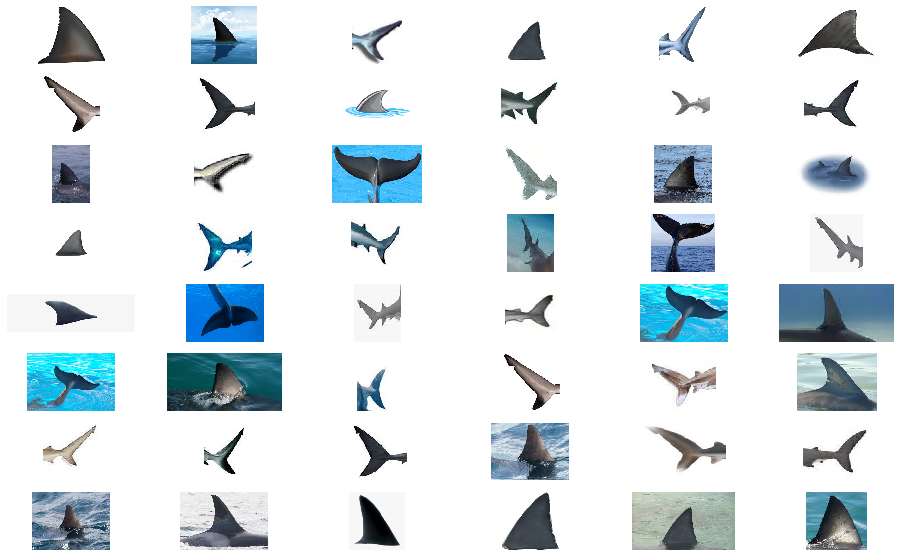

In [6]:
img_list  = os.listdir(args.train_data_path)
abs_img_paths = [os.path.join(args.train_data_path, item) for item in img_list]
show_concept_images(abs_img_paths[-48:], rows=8, fig_size=(16,10))

#### Step - 9 Top ranked images containing `fin` concepts

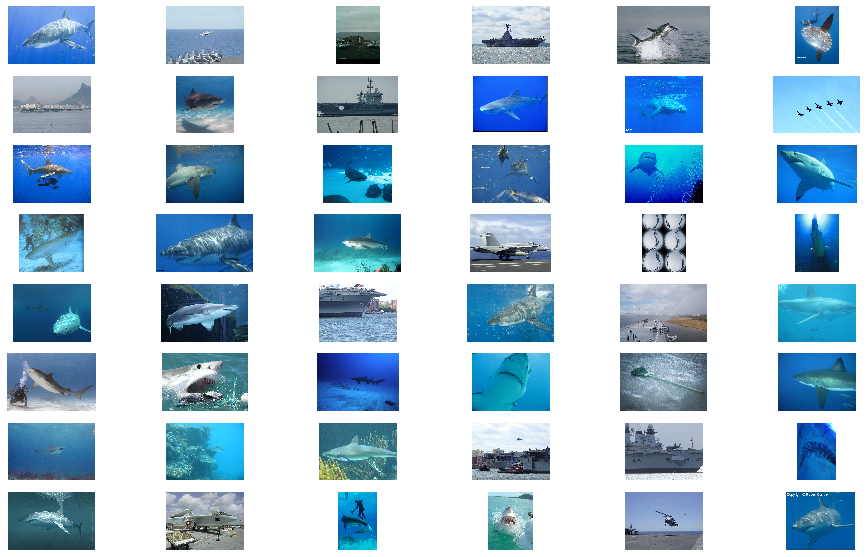

In [8]:
df_path = os.path.join(args.save_path, 'ranked_list.csv')
df = pd.read_csv(df_path)
img_list = df['image_name'].tolist()
show_concept_images(img_list[:48], rows=8, fig_size=(16,10))

#### Step 10 - Bottom ranked images containing `fin` concepts

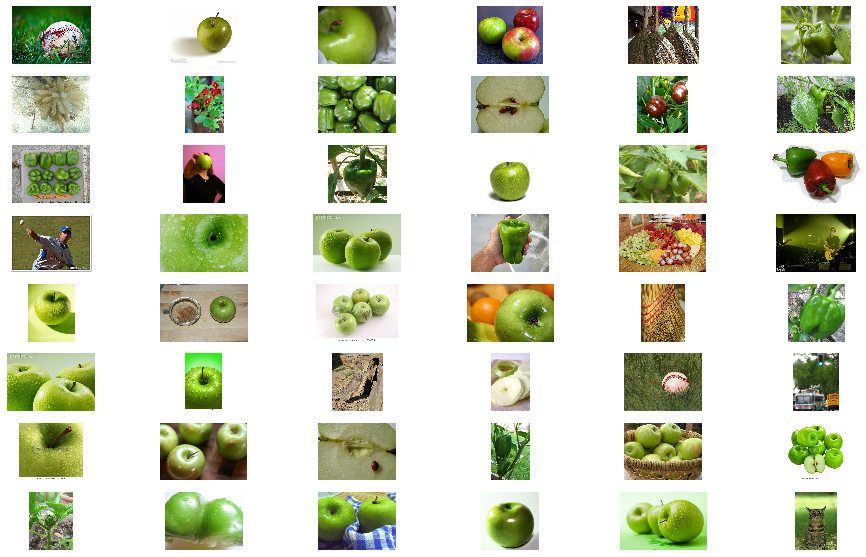

In [10]:
show_concept_images(img_list[-48:], rows=8, fig_size=(16,10))